In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

In [2]:
from models.layers import NestedDropout
from models.cmpnts import MLP, SNMLP
from models.layers import SNLinearCombo
from torch.linalg import svd

In [3]:
class PCA(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, input):
        with torch.no_grad():
            C = input.T.cov()
            L, Q = torch.linalg.eigh(C)
        return F.linear(input, Q.T)

# 2D
## 1D Manifold

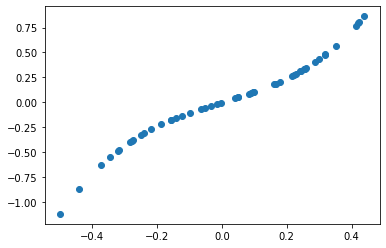

In [4]:
encoder = nn.Sequential(MLP(2, 2, [32, 32, 32]), PCA()) # MLP(2, 2, [32, 32, 32])
decoder = SNMLP(2, 2, [32, 32, 32])
encoder.train()
decoder.train()

X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = X + 5 * X ** 3 

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [5]:
data = torch.stack([X, Y], dim=-1)
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1e-2).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 0.01 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.12144500762224197, lasso = 0.017061147838830948
Epoch 100: rec = 0.0006362306303344667, lasso = 0.1102885752916336
Epoch 200: rec = 0.00011671870743157342, lasso = 0.10493575781583786
Epoch 300: rec = 3.3869237086037174e-05, lasso = 0.102052703499794
Epoch 400: rec = 2.473456333973445e-05, lasso = 0.09914886206388474
Epoch 500: rec = 1.6823001715238206e-05, lasso = 0.096257783472538
Epoch 600: rec = 1.1127147445222363e-05, lasso = 0.09271616488695145
Epoch 700: rec = 1.2142078048782423e-05, lasso = 0.09072114527225494
Epoch 800: rec = 3.773787830141373e-05, lasso = 0.08849548548460007
Epoch 900: rec = 1.1847761015815195e-05, lasso = 0.08722830563783646
Epoch 1000: rec = 7.033466772554675e-06, lasso = 0.08621085435152054
Epoch 1100: rec = 5.700454494217411e-06, lasso = 0.08469237387180328
Epoch 1200: rec = 4.794122105522547e-06, lasso = 0.08307433873414993
Epoch 1300: rec = 3.9180927160487045e-06, lasso = 0.08255589753389359
Epoch 1400: rec = 2.3953785785124637e-05, las

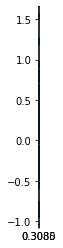

In [6]:
encoder.eval()
decoder.eval()

z = encoder(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [7]:
z.max(0)[0] - z.min(0)[0]

tensor([7.6222e-04, 2.4481e+00], grad_fn=<SubBackward0>)

In [8]:
z.T.cov()

tensor([[2.7257e-08, 1.3776e-08],
        [1.3776e-08, 2.8131e-01]], grad_fn=<SqueezeBackward0>)

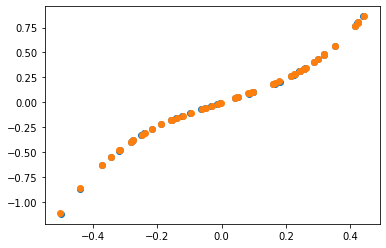

In [9]:
rec = decoder(z).detach().numpy()
plt.scatter(X.numpy(), Y.numpy())
plt.scatter(rec[:, 0], rec[:, 1])

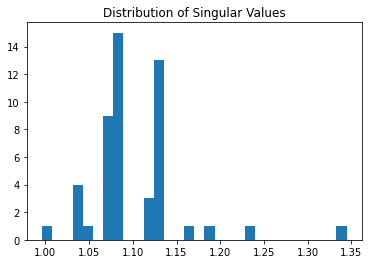

In [10]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## 2D Manifold

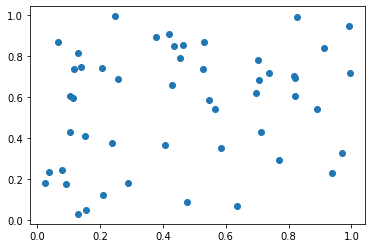

In [111]:
encoder = MLP(2, 2, [32, 32, 32]) # MLP(2, 2, [32, 32, 32]) 
decoder = SNMLP(2, 2, [32, 32, 32])
encoder.train()
decoder.train()

data = torch.rand(50, 2)
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.show()

In [112]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 0.001 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.39088982343673706, lasso = 1.0132862329483032
Epoch 100: rec = 0.03197900950908661, lasso = 2.0319619178771973
Epoch 200: rec = 0.0003386929747648537, lasso = 2.5143654346466064
Epoch 300: rec = 8.28164629638195e-05, lasso = 2.276721239089966
Epoch 400: rec = 4.678449113271199e-05, lasso = 2.0503079891204834
Epoch 500: rec = 2.392421265540179e-05, lasso = 1.8729113340377808
Epoch 600: rec = 1.7578378901816905e-05, lasso = 1.7537468671798706
Epoch 700: rec = 9.71913141256664e-06, lasso = 1.6674038171768188
Epoch 800: rec = 6.786528501834255e-06, lasso = 1.615555763244629
Epoch 900: rec = 7.86332839197712e-06, lasso = 1.569583773612976
Epoch 1000: rec = 5.305160357238492e-06, lasso = 1.5462055206298828
Epoch 1100: rec = 7.006539817666635e-06, lasso = 1.5095205307006836
Epoch 1200: rec = 5.68052973903832e-06, lasso = 1.4688830375671387
Epoch 1300: rec = 6.1036307670292445e-06, lasso = 1.4611228704452515
Epoch 1400: rec = 6.189353825902799e-06, lasso = 1.4343312978744507
E

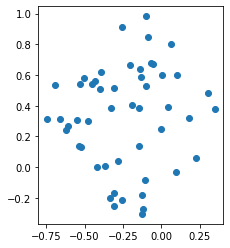

In [113]:
encoder.eval()
decoder.eval()

z = encoder(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [114]:
z.max(0)[0] - z.min(0)[0]

tensor([1.0939, 1.2879], grad_fn=<SubBackward0>)

In [115]:
z.T.cov()

tensor([[0.0691, 0.0066],
        [0.0066, 0.1097]], grad_fn=<SqueezeBackward0>)

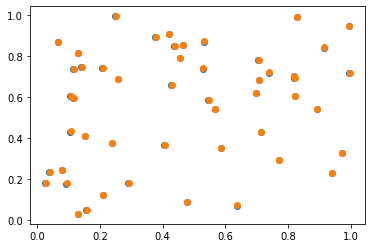

In [116]:
rec = decoder(z).detach().numpy()
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.scatter(rec[:, 0], rec[:, 1])

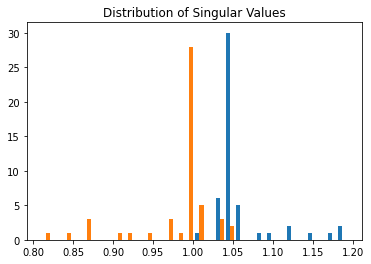

In [117]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[0, 1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## Swiss Roll

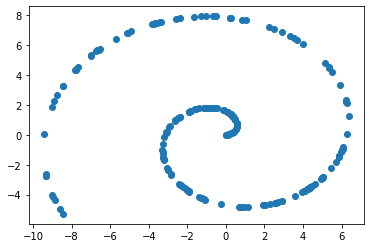

In [18]:
encoder =  MLP(2, 2, [32, 32, 32, 32]) 
decoder = SNMLP(2, 2, [32, 32, 32, 32])
encoder.train()
decoder.train()

X, _ = torch.sort(torch.rand(200)*10)
data = torch.stack([X * torch.cos(X), X * torch.sin(X)], dim=-1)
plt.scatter(data[:, 0], data[:, 1])
plt.show()

In [55]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(50000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 10 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 16.89276695251465, lasso = 0.02861848659813404
Epoch 100: rec = 16.380664825439453, lasso = 0.0017511197365820408
Epoch 200: rec = 16.380678176879883, lasso = 0.00036878586979582906
Epoch 300: rec = 16.380718231201172, lasso = 0.00180992076639086
Epoch 400: rec = 16.380706787109375, lasso = 0.000705557584296912
Epoch 500: rec = 16.380687713623047, lasso = 0.0007417819579131901
Epoch 600: rec = 16.380687713623047, lasso = 0.00021276094776112586
Epoch 700: rec = 16.380678176879883, lasso = 0.000530098332092166
Epoch 800: rec = 16.380687713623047, lasso = 0.000248874188400805
Epoch 900: rec = 16.380666732788086, lasso = 0.0003455124387983233
Epoch 1000: rec = 16.380687713623047, lasso = 0.0006027947529219091
Epoch 1100: rec = 16.38068199157715, lasso = 0.00016561071970500052
Epoch 1200: rec = 16.380691528320312, lasso = 0.00018427013128530234
Epoch 1300: rec = 16.38066864013672, lasso = 0.00024079975264612585
Epoch 1400: rec = 16.380661010742188, lasso = 0.00047543045366182

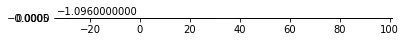

In [56]:
encoder.eval()
decoder.eval()

z = encoder(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

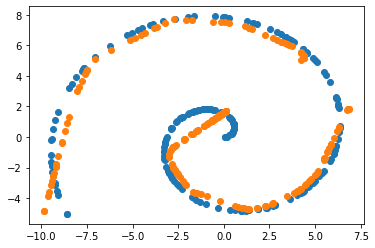

In [57]:
rec = decoder(z).detach().numpy()
plt.scatter(data[:,0].numpy(), data[:,1].numpy())
plt.scatter(rec[:, 0], rec[:, 1])

# 3D
## 1D Manifold

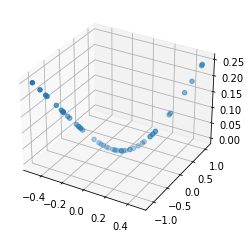

In [21]:
encoder = MLP(3, 3, [32, 32, 32, 32])
decoder = SNMLP(3, 3, [32, 32, 32, 32])
encoder.train()
decoder.train()

X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = X + 5 * X ** 3
Z = X ** 2
data = torch.stack([X, Y, Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
fig.show()

In [22]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)

for i in range(10000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1e-3).mean()) # torch.norm(z.std(0), p=1)
    # F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov())) 
    loss = rec_loss + 0.01 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.12063144892454147, lasso = 0.007588486652821302
Epoch 100: rec = 0.004212757106870413, lasso = 0.2741580009460449
Epoch 200: rec = 0.0002306433452758938, lasso = 0.1126759797334671
Epoch 300: rec = 5.8131758123636246e-05, lasso = 0.019404727965593338
Epoch 400: rec = 2.1065086912130937e-05, lasso = 0.026671046391129494
Epoch 500: rec = 1.3822070286551025e-05, lasso = 0.04522714018821716
Epoch 600: rec = 7.220643055916298e-06, lasso = 0.030869804322719574
Epoch 700: rec = 4.931194325763499e-06, lasso = 0.01834511198103428
Epoch 800: rec = 2.9761947644146858e-06, lasso = 0.01972748525440693
Epoch 900: rec = 3.409141527299653e-06, lasso = 0.025973966345191002
Epoch 1000: rec = 2.3391733066091547e-06, lasso = 0.030300520360469818
Epoch 1100: rec = 1.9050513628826593e-06, lasso = 0.020610926672816277
Epoch 1200: rec = 3.609025588957593e-05, lasso = 0.018306618556380272
Epoch 1300: rec = 1.5909646435829927e-06, lasso = 0.023285705596208572
Epoch 1400: rec = 1.646614578021399

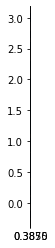

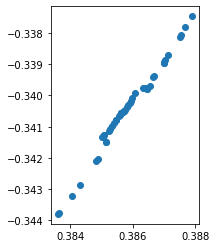

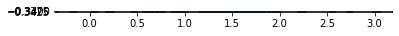

In [23]:
encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [24]:
z.max(0)[0] - z.min(0)[0]

tensor([0.0043, 3.2049, 0.0063], grad_fn=<SubBackward0>)

In [25]:
z.T.cov()

tensor([[ 9.5232e-07, -6.9268e-04,  1.3312e-06],
        [-6.9268e-04,  5.0613e-01, -9.7333e-04],
        [ 1.3312e-06, -9.7333e-04,  1.8864e-06]], grad_fn=<SqueezeBackward0>)

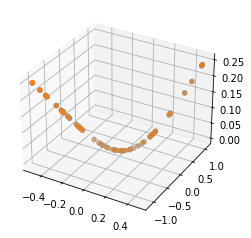

In [26]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

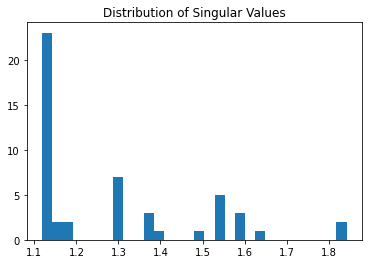

In [27]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[1]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## 2D

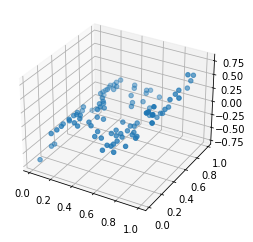

In [37]:
encoder = MLP(3, 3, [32, 32, 32, 32])
decoder = SNMLP(3, 3, [32, 32, 32, 32])
encoder.train()
decoder.train()

XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) 
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [38]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for i in range(50000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1e-2).mean()) # torch.norm(z.std(0), p=1)
    # torch.abs(z.T.cov().tril(diagonal=-1)).mean()
    loss = rec_loss + 0.001 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.23900863528251648, lasso = 0.01431570015847683
Epoch 100: rec = 0.16350695490837097, lasso = 0.017052648589015007
Epoch 200: rec = 0.08778583258390427, lasso = 0.04378630593419075
Epoch 300: rec = 0.07472283393144608, lasso = 0.13477157056331635
Epoch 400: rec = 0.06969687342643738, lasso = 0.2746453583240509
Epoch 500: rec = 0.05767935886979103, lasso = 0.6177809238433838
Epoch 600: rec = 0.04564044997096062, lasso = 1.0793380737304688
Epoch 700: rec = 0.043539900332689285, lasso = 1.0358906984329224
Epoch 800: rec = 0.04162408784031868, lasso = 0.9961824417114258
Epoch 900: rec = 0.03971177712082863, lasso = 1.0117310285568237
Epoch 1000: rec = 0.03756696358323097, lasso = 1.0097092390060425
Epoch 1100: rec = 0.035086795687675476, lasso = 1.0386266708374023
Epoch 1200: rec = 0.03144031763076782, lasso = 1.056612491607666
Epoch 1300: rec = 0.023694267496466637, lasso = 1.0827832221984863
Epoch 1400: rec = 0.010482433252036572, lasso = 1.3439363241195679
Epoch 1500: re

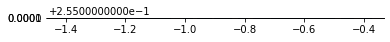

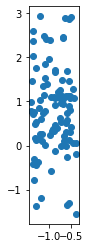

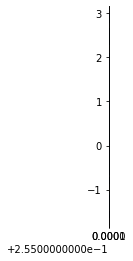

In [39]:
encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [40]:
z.max(0)[0] - z.min(0)[0]

tensor([1.0230e+00, 2.2277e-04, 4.4880e+00], grad_fn=<SubBackward0>)

In [41]:
z.T.cov()

tensor([[ 9.4486e-02,  5.0392e-06, -6.1104e-03],
        [ 5.0392e-06,  1.7176e-09, -1.2787e-05],
        [-6.1104e-03, -1.2787e-05,  9.5633e-01]], grad_fn=<SqueezeBackward0>)

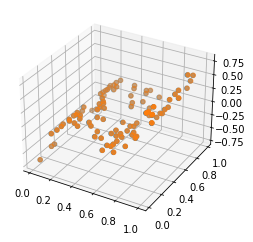

In [42]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

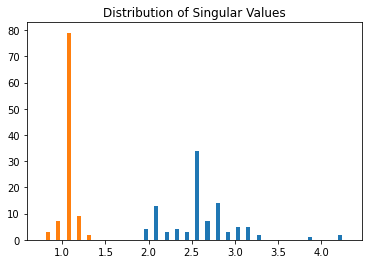

In [44]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[0, 2]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

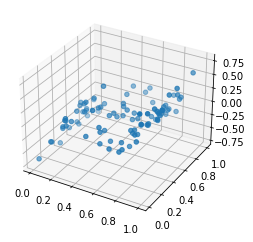

In [101]:
encoder = MLP(3, 3, [128]*4)
decoder = SNMLP(3, 3, [128]*4)
encoder.train()
decoder.train()

XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) + torch.randn(len(X))/10
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [102]:
opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)

for i in range(50000):
    opt.zero_grad()
    z = encoder(data)
    rec_loss = F.mse_loss(decoder(z), data) 
    lasso_loss = torch.exp(torch.log(z.std(0)+1).mean())  # torch.norm(z.std(0), p=1)
    # lasso_loss = F.mse_loss(z.T.cov().tril(diagonal=-1), torch.zeros_like(z.T.cov()))
    loss = rec_loss + 0.01 * lasso_loss
    loss.backward()
    opt.step()

    if i % 100 == 0:
        print('Epoch {}: rec = {}, lasso = {}'.format(i, rec_loss, lasso_loss))

Epoch 0: rec = 0.283099502325058, lasso = 1.0033305883407593
Epoch 100: rec = 0.08088672161102295, lasso = 1.0235631465911865
Epoch 200: rec = 0.056914132088422775, lasso = 1.4831210374832153
Epoch 300: rec = 0.03180455043911934, lasso = 1.5278148651123047
Epoch 400: rec = 0.02942732721567154, lasso = 1.4649685621261597
Epoch 500: rec = 0.026777897030115128, lasso = 1.4868236780166626
Epoch 600: rec = 0.02409227192401886, lasso = 1.4949626922607422
Epoch 700: rec = 0.022061387076973915, lasso = 1.4904077053070068
Epoch 800: rec = 0.019718535244464874, lasso = 1.5011354684829712
Epoch 900: rec = 0.01392630860209465, lasso = 1.628039002418518
Epoch 1000: rec = 0.0037605385296046734, lasso = 1.6921484470367432
Epoch 1100: rec = 0.002703274367377162, lasso = 1.620352029800415
Epoch 1200: rec = 0.0023204416502267122, lasso = 1.6018160581588745
Epoch 1300: rec = 0.002043064683675766, lasso = 1.5486931800842285
Epoch 1400: rec = 0.0019525683019310236, lasso = 1.5241847038269043
Epoch 1500: re

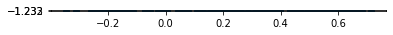

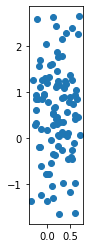

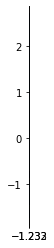

In [103]:
encoder.eval()
decoder.eval()

z = encoder(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [104]:
z.max(0)[0] - z.min(0)[0]

tensor([1.0579e+00, 1.0220e-03, 4.2820e+00], grad_fn=<SubBackward0>)

In [105]:
z.T.cov()

tensor([[ 7.6880e-02,  5.3162e-06,  5.3196e-03],
        [ 5.3162e-06,  5.9061e-08, -1.6773e-04],
        [ 5.3196e-03, -1.6773e-04,  1.0156e+00]], grad_fn=<SqueezeBackward0>)

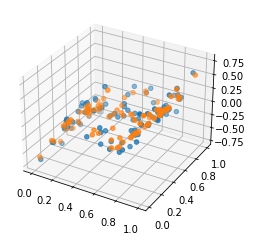

In [106]:
rec = decoder(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

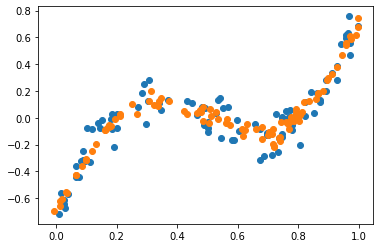

In [107]:
plt.scatter(XY[:,0].numpy(), Z.numpy())
plt.scatter(rec[:, 0], rec[:, 2])
plt.show()

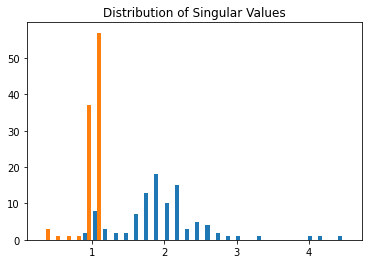

In [110]:
def f(x):
    return encoder(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j[[0, 2]])[1] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()